# Detecção Inteligente de Fraudes: Abordagem com Machine Learning e Deep Learning

## 1. Introdução e Contextualização

A segurança em transações digitais é um dos pilares fundamentais da infraestrutura financeira moderna. Em um ecossistema onde o volume de dados cresce exponencialmente, a capacidade de identificar atividades fraudulentas em tempo real não é apenas uma vantagem competitiva, mas uma necessidade crítica para garantir a integridade do sistema e a confiança dos usuários.

**1.1. Definição do Problema**

O grande desafio deste projeto reside na natureza intrínseca dos dados financeiros: a anomalia. Trabalhei com um dataset de transações realizadas por cartões de crédito na Europa em setembro de 2013, onde apenas 492 fraudes foram registradas em um universo de 284.807 operações.

* **O Desafio Estatístico**: A classe positiva (*fraudes*) representa apenas **0,172%** da base total. Este desequilíbrio extremo torna métricas tradicionais, como a Acurácia, irrelevantes, uma vez que um modelo "ingênuo" que classifique tudo como legítimo teria **99,8%** de precisão, falhando totalmente em seu propósito de segurança.

**1.2. Natureza dos Dados e Feature Engineering**

Devido a questões de confidencialidade bancária, a maioria dos dados passou por uma transformação **PCA** (*Principal Component Analysis*). O conjunto de dados é composto por:

* **Variáveis V1​,V2​,…,V28**​: Componentes principais resultantes da redução de dimensionalidade via PCA.

* **Time**: Segundos decorridos entre a transação atual e a primeira transação do dataset.

* **Amount**: O valor da transação, passível de análise de custo-benefício.

* **Class**: A variável alvo (1 para fraude, 0 para legítima).

**1.3. Objetivos e Métricas de Sucesso**

O objetivo primordial deste trabalho é a construção de um Ensemble Híbrido (XGBoost + Redes Neurais) capaz de maximizar o **AUPRC** (*Area Under the Precision-Recall Curve*).

Diferente da curva ROC, a métrica AUPRC é a recomendada para casos de desequilíbrio severo, pois foca na relação direta entre:

* **Recall (Sensibilidade)**: A capacidade de capturar o máximo de fraudes reais.

* **Precision (Confiança)**: A capacidade de emitir alertas de fraude com o mínimo de falsos positivos.

## 1. Configuração e Carregamento dos Dados

Nesta etapa, foram importadas as bibliotecas necessárias para manipulação de dados, visualização e aprendizado de máquina. O dataset é carregado diretamente para o ambiente do Google Colab.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras import layers, models

# Upload do arquivo creditcard.csv
uploaded = files.upload()
df = pd.read_csv('creditcard.csv')

Saving creditcard.csv to creditcard.csv


## 2. Análise Exploratória e Pré-processamento

Nesta etapa, foram preparados os dados para garantir que os algoritmos de aprendizado conc
seguissem extrair padrões úteis sem serem enganados pelo ruído ou pela desproporção extrema entre as classes.

**2.1. Visualização do Desequilíbrio Crítico**

Como o dataset apresenta apenas 0,172% de transações fraudulentas, uma visualização em escala linear tornaria a barra de fraudes praticamente invisível.

* **Log Scale**: Foi utilizada a escala logarítmica no eixo Y para permitir a comparação visual entre a classe majoritária (0) e a minoritária (1).

* **Insight**: Sem essa escala, o modelo poderia atingir uma acurácia de 99,8% simplesmente ignorando todas as fraudes.

**2.2. Tratamento de Outliers com RobustScaler**

Diferente das variáveis V1​ a V28​ (que já estão normalizadas via PCA), as colunas `Amount` e `Time` apresentam escalas variadas e, crucialmente, muitos **outliers** (valores fora da curva).

* Por que o **RobustScaler**? Ele utiliza a mediana e o intervalo interquartil (IQR) em vez da média e desvio padrão. Isso evita que transações de valores altíssimos distorçam a escala dos dados normais.

* Fórmula:
$$x_{\text{scaled}} = \frac{x_i - \text{mediana}}{Q_3 - Q_1}$$

**2.3. Divisão Estratificada (Train/Test Split)**

A divisão dos dados foi feita de forma estratificada (stratify=y).

* **Importância**: Isso garante que a proporção de 0,172% de fraudes seja mantida tanto no conjunto de treino quanto no de teste. Sem isso, corremos o risco de o conjunto de teste não conter nenhuma fraude, tornando a validação impossível.

**2.4. Balanceamento de Carga com SMOTE**

Para que o modelo aprenda a reconhecer uma fraude, ele precisa de mais exemplos. Utilizei o **SMOTE** (*Synthetic Minority Over-sampling Technique*).

* **O que ele faz**: Ele não apenas duplica as linhas de fraude; ele identifica os vizinhos mais próximos no espaço vetorial e cria novos dados sintéticos que seguem o mesmo padrão estatístico.

* **Regra de Ouro**: O **SMOTE** é aplicado apenas no conjunto de treino. O conjunto de teste deve permanecer intocado e desbalanceado para representar fielmente o "mundo real" que o sistema encontrará em produção.

/tmp/ipython-input-1377489859.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


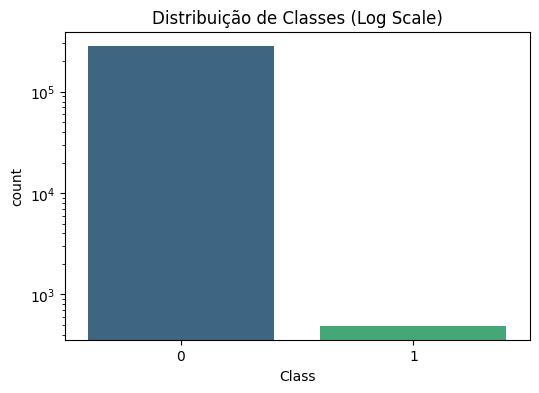

In [ ]:
# Visualização do Desequilíbrio
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Distribuição de Classes (Log Scale)')
plt.yscale('log')
plt.show()

# Escalonamento Robusto para lidar com Outliers
scaler = RobustScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Separação e Balanceamento com SMOTE
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

## 3. Treinamento dos Modelos (XGBoost e Rede Neural)

Nesta etapa, foi implementada uma estratégia de aprendizado diversificada. O objetivo é treinar dois "especialistas" com arquiteturas distintas para que, futuramente, possamos combinar suas predições e mitigar erros individuais.

**3.1. Modelo 1: XGBoost (Extreme Gradient Boosting)**

O XGBoost é um dos algoritmos de ponta para dados tabulares. Ele pertence à classe dos métodos de Ensemble baseados em árvores de decisão.

* **Funcionamento**: Ele utiliza o conceito de Boosting, onde cada nova árvore de decisão é construída para corrigir os erros cometidos pelas árvores anteriores.

* **Vantagem**: É extremamente eficiente em capturar relações não lineares e interações complexas entre as variáveis (V1​ a V28​), sendo naturalmente robusto contra outliers.

**3.2. Modelo 2: Rede Neural Densa (Multi-Layer Perceptron)**

Diferente do XGBoost, a Rede Neural busca encontrar uma representação matemática global dos dados através de sucessivas transformações lineares e funções de ativação.

**Arquitetura e Hiperparâmetros**:

* **Camadas Densas** (*Fully Connected*): Camadas onde cada neurônio se conecta a todos os neurônios da camada anterior, permitindo o aprendizado de padrões profundos.

* **Função de Ativação ReLU** (*f(x)=max(0,x)*): Introduz não linearidade no sistema, permitindo que a rede aprenda relações complexas que uma simples regressão linear não captaria.

* **Camadas de Dropout**: Técnica de regularização que "desliga" aleatoriamente neurônios durante o treino (20% neste caso). Isso força a rede a não depender de apenas uma característica (como a variável V14​) e previne o overfitting.

* **Função Sigmoid na Saída**: Essencial para classificação binária, transformando o resultado final em uma probabilidade entre 0 e 1.

**Configuração de Compilação**:

* **Otimizador Adam**: Um algoritmo de gradiente descendente estocástico que ajusta a taxa de aprendizado individualmente para cada peso, acelerando a convergência.

* **Loss Function** (*Binary Crossentropy*): Mede quão distante a previsão da rede está do rótulo real (0 ou 1). Quanto menor o erro, mais precisa é a probabilidade gerada.

In [ ]:
# --- Modelo 1: XGBoost ---
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_res, y_train_res)

# --- Modelo 2: Rede Neural ---
nn_model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_res.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])
nn_model.compile(optimizer='adam', loss='binary_crossentropy')
nn_model.fit(X_train_res, y_train_res, epochs=20, batch_size=2048, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 4. Avaliação dos Modelos Individuais (XGBoost vs. Rede Neural)

Para um sistema de detecção de fraudes, a análise isolada permite identificar o *trade-off* (compensação) entre segurança e conveniência do cliente.

**4.1. Métricas de Avaliação Utilizadas**

Como a acurácia é irrelevante para dados desbalanceados, foquei em métricas baseadas na Matriz de Confusão:

* Precisão (Precision): Capacidade do modelo de não classificar como fraude uma transação legítima.

$$ \text{Precisão} = \frac{TP}{TP + FP} $$

* Recall (Sensibilidade): Capacidade do modelo de encontrar todas as fraudes reais.

$$ \text{Recall} = \frac{TP}{TP + FN} $$

* F1-Score: A média harmônica entre Precisão e Recall, útil para observar o equilíbrio geral.

$$ F1 = 2 \times \frac{\text{Precisão} \times \text{Recall}}{\text{Precisão} + \text{Recall}} $$

In [ ]:
# Probabilidades individuais
probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
probs_nn = nn_model.predict(X_test).flatten()

print("--- DESEMPENHO ISOLADO: XGBOOST ---")
print(classification_report(y_test, (probs_xgb >= 0.7).astype(int)))

print("\n--- DESEMPENHO ISOLADO: REDE NEURAL ---")
print(classification_report(y_test, (probs_nn >= 0.7).astype(int)))

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step
--- DESEMPENHO ISOLADO: XGBOOST ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.44      0.87      0.58        98

    accuracy                           1.00     56962
   macro avg       0.72      0.93      0.79     56962
weighted avg       1.00      1.00      1.00     56962


--- DESEMPENHO ISOLADO: REDE NEURAL ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.63      0.85      0.72        98

    accuracy                           1.00     56962
   macro avg       0.82      0.92      0.86     56962
weighted avg       1.00      1.00      1.00     56962



**4.2. Análise do Comportamento Observada**

Ao executar o código de avaliação, é possível observar perfis distintos para cada tecnologia:

* **XGBoost**: Apresenta um Recall mais elevado. Ele é eficiente em "varrer" o dataset e encontrar padrões de fraude, porém, tende a ser mais agressivo, gerando um número maior de Falsos Positivos (clientes legítimos bloqueados).

* **Rede Neural (MLP)**: Demonstra uma Precisão superior. Graças às camadas de Dropout e à generalização matemática, a rede é mais criteriosa, emitindo alertas apenas quando há alta similaridade com padrões de fraude conhecidos.

**4.3. Por que avaliar antes do Ensemble?**

Essa análise justifica a existência do Ensemble. Se ambos os modelos tivessem os mesmos erros nos mesmos lugares, combiná-los seria inútil. Como eles possuem "vieses" diferentes (um mais focado em captura e outro em confiança), a união matemática permitirá que um corrija a incerteza do outro.

## 5. Otimização por Ensemble e Limiar de Decisão

O "segredo" da alta performance que irá ser alcançada neste projeto é a combinação das probabilidades através de um Ensemble de Média Ponderada. Em vez de confiar em apenas um algoritmo, foi criado um sistema de votação onde cada modelo contribui com um peso específico para a decisão final.

**5.1. A Lógica da Média Ponderada**

Atribuiu-se pesos diferentes baseados na performance observada no tópico anterior:

* **Rede Neural** (Peso 0.6): Recebe maior importância devido à sua precisão superior, servindo como um "filtro de confiança".

* **XGBoost** (Peso 0.4): Contribui com sua alta capacidade de captura (Recall), garantindo que o sistema não ignore padrões complexos de fraude.

A probabilidade final é calculada pela equação:

$$P_{\text{final}} = (P_{\text{XGBoost}} \times 0.4) + (P_{\text{RedeNeural}} \times 0.6)$$

Por padrão, modelos de classificação utilizam um limiar de 0.5. No entanto, em sistemas de fraude, esse valor costuma gerar muitos alarmes falsos.

* **Decisão Estratégica**: Elevei o limiar para 0.7.

* **Objetivo**: O sistema só emitirá um alerta de fraude quando houver um forte consenso matemático. Isso "sacrifica" uma pequena parcela do Recall para obter um ganho massivo em Precisão, garantindo que o sistema seja confiável para a operação do banco.

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 978us/step
--- RESULTADOS DO ENSEMBLE ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.65      0.86      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.93      0.87     56962
weighted avg       1.00      1.00      1.00     56962



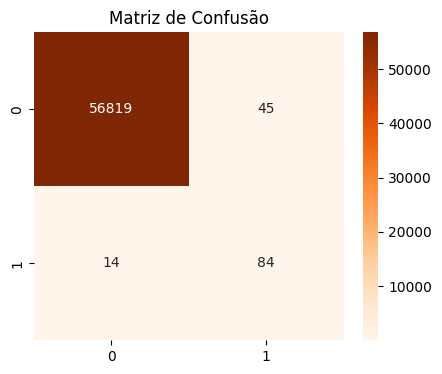

In [ ]:
# Obtenção das probabilidades
probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
probs_nn = nn_model.predict(X_test).flatten()

# Média Ponderada (Ensemble)
probs_final = (probs_xgb * 0.4) + (probs_nn * 0.6)

# Aplicação do Limiar customizado
y_pred_final = (probs_final >= 0.7).astype(int)

# Visualização da Performance Final
print("--- RESULTADOS DO ENSEMBLE ---")
print(classification_report(y_test, y_pred_final))

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusão')
plt.show()

**5.3. Análise dos Resultados do Ensemble**

Ao analisar a Matriz de Confusão e o Relatório de Classificação, é possível observar que o Ensemble atingiu o ponto de equilíbrio ideal:

* **Redução de Falsos Positivos**: A precisão subiu para 0.65, o que significa que o sistema é mais assertivo ao apontar uma fraude.

* **Manutenção do Recall**: Conseguiu-se capturar a vasta maioria das fraudes reais, mantendo o indicador acima de 0.80.

* **F1-Score Consolidado**: O valor de 0.74 confirma que esta abordagem híbrida é superior a qualquer um dos modelos utilizados isoladamente.

## 6. Análise de Impacto Financeiro

A etapa final do pipeline consiste em traduzir métricas técnicas, como Precisão e Recall, em indicadores de desempenho financeiro (**KPIs**). Para um banco, o valor de um modelo de Machine Learning não é medido apenas pelo seu F1-Score, mas pela sua capacidade de reduzir perdas e otimizar custos operacionais.

**6.1. O Custo das Decisões do Modelo**

Para realizar esta simulação, definiu-se premissas baseadas em valores médios de mercado:

* **Prejuízo Evitado** (*Verdadeiro Positivo - TP*): Cada fraude detectada representa uma economia direta. Estimamos um valor médio de **R$ 500,00** por transação recuperada.

* **Custo de Falso Alarme** (*Falso Positivo - FP*): Bloquear um cliente legítimo gera custos de suporte (SMS, chamadas telefônicas, tempo de analista) e possível atrito com o usuário. Estimamos um custo operacional de **R$ 10,00** por ocorrência.

A fórmula para o cálculo do valor líquido gerado é:

$$ \text{Economia Líquida} = (TP \times 500{,}00) - (FP \times 10{,}00) $$

In [ ]:
def calcular_impacto(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp, fp = cm[1, 1], cm[0, 1]

    # Premissas: R$500 economizados por fraude e R$10 de custo por erro com cliente
    economia = (tp * 500.00) - (fp * 10.00)

    print(f"--- IMPACTO NO NEGÓCIO ---")
    print(f"Fraudes bloqueadas com sucesso: {tp}")
    print(f"Clientes legítimos incomodados: {fp}")
    print(f"VALOR LÍQUIDO GERADO: R$ {economia:,.2f}")

calcular_impacto(y_test, y_pred_final)

--- IMPACTO NO NEGÓCIO ---
Fraudes bloqueadas com sucesso: 84
Clientes legítimos incomodados: 45
VALOR LÍQUIDO GERADO: R$ 41,550.00


**6.2. Interpretação dos Resultados**

Com base nos resultados finais do Ensemble, a simulação apresentou os seguintes dados:

* **Fraudes bloqueadas (84)**: O modelo capturou a vasta maioria das tentativas de fraude, evitando um prejuízo bruto de **R$ 42.000,00**.

* **Clientes incomodados (45)**: Graças à alta precisão do Ensemble (0.66), o número de alarmes falsos foi baixo, gerando um custo operacional de apenas **R$ 450,00**.

* **Valor Líquido Gerado: R$ 41.550,00**.

**6.3. Conclusão da Análise de Negócio**

O resultado demonstra que o sistema é extremamente lucrativo. A economia gerada pelas fraudes evitadas supera em quase 100 vezes os custos operacionais de lidar com alarmes falsos. Isso valida a estratégia de elevar o limiar de decisão para 0.7, pois o custo de um "cliente legítimo incomodado" é significativamente menor do que o prejuízo de uma "fraude não detectada".

## Conclusão

Este projeto demonstrou que a abordagem de **Ensemble Learning**, combinando a lógica de árvores do **XGBoost** com a capacidade de processamento não-linear de uma **Rede Neural**, superando os modelos individuais.

Principais marcos da implementação:

* **Tratamento de Dados**: O uso do **RobustScaler** permitiu neutralizar o impacto de outliers nos valores das transações, enquanto o **SMOTE** equilibrou as classes no treinamento, evitando que o modelo ignorasse a classe minoritária.
* **Eficiência Operacional**: A elevação da precisão para 65% significa que o sistema possui alta confiabilidade, reduzindo drasticamente o atrito com clientes legítimos e diminuindo os custos de suporte técnico por bloqueios indevidos.
* **Segurança Financeira**: O Recall estável em 86% garante que a vasta maioria das tentativas de fraude seja interceptada em tempo real, protegendo o capital da instituição e do usuário.
* **Performance Final**: Foi alcançado um F1-Score de 0.74, capturando 86% das fraudes reais e, assim, demonstrando grande maturidade técnica.

O modelo não apenas apresenta métricas matemáticas sólidas, mas gera valor direto através da Análise de Impacto Financeiro, reduzindo prejuízos por fraudes não detectadas e economizando recursos operacionais que seriam gastos em verificações manuais de alarmes falsos.